In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [219]:
pwd = os.getcwd()
print(pwd)

e:\review_from_sb\suplementary\simonin_model


In [220]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size']=6

In [221]:
raw_df = pd.read_excel(pwd + '/data/NbN.xlsx')
print(f'Shape of the imported dataset is: ', raw_df.shape)
raw_df.head()

Shape of the imported dataset is:  (94, 6)


,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,Al2O3,600.0,6.756078,4.3,11.00
1,DcMs,Al2O3,600.0,6.756078,4.4,11.30
2,DcMs,Al2O3,600.0,6.756078,4.4,11.10
3,DcMs,Al2O3,600.0,6.756078,10.0,14.30
4,DcMs,Al2O3,750.0,0.500000,3.2,9.87


In [222]:
def percentageOfnull(df):
    nan_count = df.isna().sum().sort_values(ascending=False)
    nan_percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)
    train_test_dtype = df.dtypes
    df_info = pd.concat([nan_count,nan_percentage,train_test_dtype],axis=1,keys=['Null Count','Null Percentage','DataTypes'])
    return df_info[df_info['Null Count']>0]


percentageOfnull(raw_df)

,Null Count,Null Percentage,DataTypes


In [223]:
df = raw_df.copy()

In [224]:
numerical_feats = list(df.drop('Tc_K',axis=1).select_dtypes(include='number'))
categorical_feats = list(df.select_dtypes(exclude='number'))
num_feats = [item for item in numerical_feats]

method_list = [df['method'].unique()]
substrate_list = [df['substrate'].unique()]

for col in df.select_dtypes(exclude=['number']):
  print(f'{col:-<30}, {df[col].unique()}')

method------------------------, ['DcMs' 'IBAS' 'RfMs' 'PLD' 'IBAD']
substrate---------------------, ['Al2O3' 'GaAs' 'LiNbO3' 'MgF2' 'MgO' 'Si' 'SiN' 'HfO2']


In [225]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from sklearn.preprocessing import StandardScaler

LABELS = df.drop('Tc_K', axis=1).columns
encoder = LabelEncoder()
for col in LABELS:
    # Check if object
    if df[col].dtype == 'O':
        df[col] = encoder.fit_transform(df[col])
        
    elif df[col].dtype == 'bool':
        df[col] = df[col].astype('int')

scaler = MinMaxScaler()

# Apply Standard Scaling
#df[num_feats] = scaler.fit_transform(df[num_feats])
df.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,0,0,600.0,6.756078,4.3,11.00
1,0,0,600.0,6.756078,4.4,11.30
2,0,0,600.0,6.756078,4.4,11.10
3,0,0,600.0,6.756078,10.0,14.30
4,0,0,750.0,0.500000,3.2,9.87


In [226]:
encoded_method = [df['method'].unique()]
encoded_substrate = [df['substrate'].unique()]
#print(encoded_method)
#print(encoded_substrate)


from itertools import chain
df_method = pd.DataFrame()
df_substrate = pd.DataFrame()

df_method['method'] = pd.Series(list(chain.from_iterable(method_list)))
df_substrate['substrate'] = pd.Series(list(chain.from_iterable(substrate_list)))
df_method['Encoded_method'] = pd.Series(list(chain.from_iterable(encoded_method)))
df_substrate['Encoded_substrate'] = pd.Series(list(chain.from_iterable(encoded_substrate)))


print(df_method)
print(df_substrate)

  method  Encoded_method
0   DcMs               0
1   IBAS               2
2   RfMs               4
3    PLD               3
4   IBAD               1
  substrate  Encoded_substrate
0     Al2O3                  0
1      GaAs                  1
2    LiNbO3                  3
3      MgF2                  4
4       MgO                  5
5        Si                  6
6       SiN                  7
7      HfO2                  2


In [227]:
X = df.drop(["Tc_K"], axis=1)
y = df.Tc_K

X.head()

,method,substrate,temperature,pressure,thickness
0,0,0,600.0,6.756078,4.3
1,0,0,600.0,6.756078,4.4
2,0,0,600.0,6.756078,4.4
3,0,0,600.0,6.756078,10.0
4,0,0,750.0,0.500000,3.2


In [228]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shapes of X_train, y_train, X_test, and y_test are {}, {}, {} and {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shapes of X_train, y_train, X_test, and y_test are (75, 5), (75,), (19, 5) and (19,)


In [229]:
def prediction_error_plot(predicted_train, predicted_test, y1=y_train, y2=y_test):
    plt.style.use('default')
    plt.figure()
    plt.scatter(y1, predicted_train, c='r', label='Train data')
    plt.scatter(y2, predicted_test, c='b', label='Test data')
    plt.plot(y_train, y_train, c='r')
    plt.xlabel('Actual T_c (K)')
    plt.ylabel('Predicted T_c (K)')
    plt.legend()
    return plt.show()

In [230]:
def model_builder(model_name):
    model_name.fit(X_train, y_train)
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)

    
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print("r2 on train set: {:.4f}".format(r2_train))
    print("r2 on test set: {:.4f}".format(r2_test))
    prediction_error_plot(y_pred_train, y_pred_test)

The mean squared error (MSE) on test set: 2.4158
The root mean squared error (RMSE) on test set: 1.5543
The mean absolute error (MAE) on test set: 1.3073
r2 on train set: 0.9033
r2 on test set: 0.5568


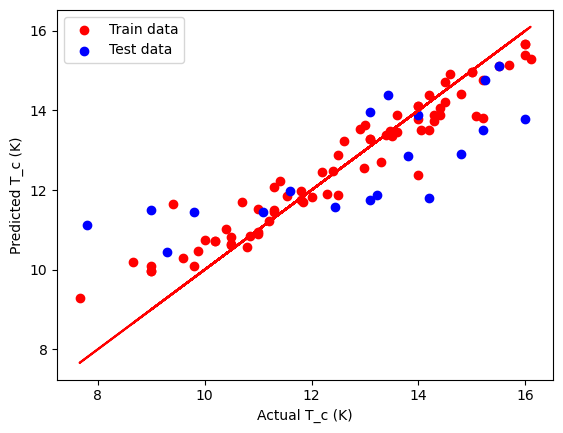

In [231]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


rf = RandomForestRegressor(random_state = 42)
model_builder(rf)

The mean squared error (MSE) on test set: 2.3851
The root mean squared error (RMSE) on test set: 1.5444
The mean absolute error (MAE) on test set: 1.3121
r2 on train set: 0.8743
r2 on test set: 0.5624


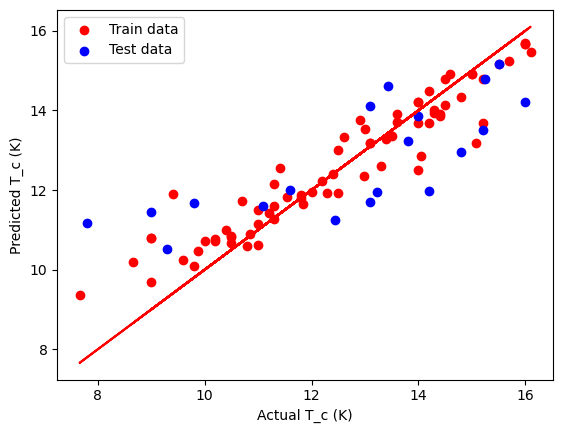

In [232]:
tuned_rf = RandomForestRegressor(max_depth = 30 , min_samples_leaf = 1
                                      , max_features=1.0, n_estimators=30, n_jobs=-1 , random_state = 42)


model_builder(tuned_rf)

The mean squared error (MSE) on test set: 1.5583
The root mean squared error (RMSE) on test set: 1.2483
The mean absolute error (MAE) on test set: 0.9729
r2 on train set: 0.9952
r2 on test set: 0.7141


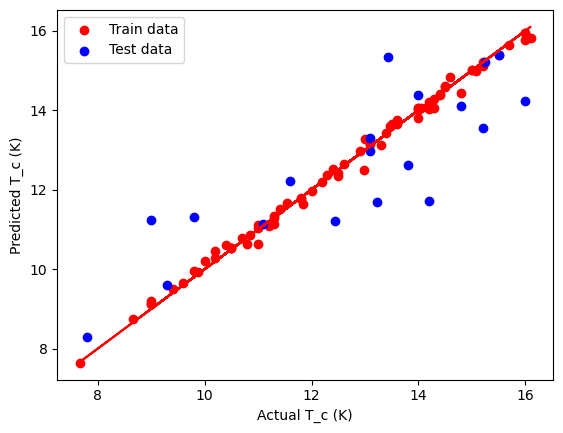

In [233]:
params = {
    "n_estimators": 250,
    "max_depth": 7,
    "min_samples_split": 13,
    "learning_rate": 0.05,
    "loss": "squared_error",
}

from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor(**params)
model_builder(gbr)

In [234]:
raw_df_sorted = raw_df.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
raw_df_sorted.head(10)

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,MgO,400.00,0.333306,140.0,16.10
1,DcMs,Al2O3,850.00,1.000000,27.0,16.00
2,PLD,MgO,600.00,7.999340,200.0,16.00
3,PLD,MgO,600.00,7.999340,200.0,16.00
4,RfMs,MgO,25.00,0.266645,200.0,16.00
5,DcMs,Al2O3,26.85,1.719858,500.0,15.70
6,PLD,MgO,600.00,3.159740,100.0,15.50
7,PLD,MgO,600.00,3.159740,100.0,15.50
8,DcMs,Al2O3,750.00,0.500000,14.4,15.25
9,DcMs,Al2O3,750.00,0.500000,11.7,15.20


In [235]:
df_DcMs = raw_df[raw_df['method'] == 'DcMs']
df_DcMs = df_DcMs.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_DcMs.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,MgO,400.00,0.333306,140.0,16.10
1,DcMs,Al2O3,850.00,1.000000,27.0,16.00
2,DcMs,Al2O3,26.85,1.719858,500.0,15.70
3,DcMs,Al2O3,750.00,0.500000,14.4,15.25
4,DcMs,Al2O3,750.00,0.500000,11.7,15.20


In [236]:
df_PLD = raw_df[raw_df['method'] == 'PLD']
df_PLD = df_PLD.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_PLD.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,PLD,MgO,600.0,7.99934,200.0,16.0
1,PLD,MgO,600.0,7.99934,200.0,16.0
2,PLD,MgO,600.0,3.15974,100.0,15.5
3,PLD,MgO,600.0,3.15974,100.0,15.5
4,PLD,Al2O3,200.0,5.00000,50.0,15.2


In [237]:
df_IBAD = raw_df[raw_df['method'] == 'IBAD']
df_IBAD = df_IBAD.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_IBAD.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,IBAD,MgO,399.85,5.0,50.0,14.0


In [238]:
df_RfMs = raw_df[raw_df['method'] == 'RfMs']
df_RfMs = df_RfMs.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_RfMs.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,RfMs,MgO,25.0,0.266645,200.0,16.0
1,RfMs,MgO,25.0,1.333224,200.0,14.5
2,RfMs,Si,30.0,1.000000,28.0,13.6
3,RfMs,Al2O3,350.0,6.756078,5.0,9.6


In [239]:
df_MgO = raw_df[raw_df['substrate'] == 'MgO']
df_MgO = df_MgO.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_MgO.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,MgO,400.0,0.333306,140.0,16.1
1,RfMs,MgO,25.0,0.266645,200.0,16.0
2,PLD,MgO,600.0,7.999340,200.0,16.0
3,PLD,MgO,600.0,7.999340,200.0,16.0
4,PLD,MgO,600.0,3.159740,100.0,15.5


In [240]:
df_Si = raw_df[raw_df['substrate'] == 'Si']
df_Si = df_Si.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_Si.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,PLD,Si,800.0,66.700000,25.0,15.07
1,DcMs,Si,600.0,0.100000,50.0,14.80
2,DcMs,Si,600.0,2.000000,400.0,14.80
3,IBAS,Si,25.0,0.266645,240.0,14.50
4,DcMs,Si,25.0,0.266645,240.0,14.40


In [241]:
df_SiN = raw_df[raw_df['substrate'] == 'SiN']
df_SiN = df_SiN.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_SiN.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,PLD,SiN,600.0,9.332566,200.0,12.0
1,PLD,SiN,600.0,7.999340,200.0,11.0
2,PLD,SiN,600.0,10.665800,200.0,11.0
3,PLD,SiN,600.0,6.666118,200.0,9.0


In [242]:
df_Al2O3 = raw_df[raw_df['substrate'] == 'Al2O3']
df_Al2O3 = df_Al2O3.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_Al2O3.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,Al2O3,850.00,1.000000,27.0,16.00
1,DcMs,Al2O3,26.85,1.719858,500.0,15.70
2,DcMs,Al2O3,750.00,0.500000,14.4,15.25
3,PLD,Al2O3,200.00,5.000000,50.0,15.20
4,DcMs,Al2O3,750.00,0.500000,11.7,15.20


In [243]:
df_GaAs = raw_df[raw_df['substrate'] == 'GaAs']
df_GaAs = df_GaAs.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_GaAs.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,GaAs,400.0,0.333306,140.00,14.6
1,DcMs,GaAs,400.0,0.330000,4.12,14.0
2,DcMs,GaAs,350.0,0.500000,22.00,12.6
3,DcMs,GaAs,400.0,0.333306,10.00,12.5
4,DcMs,GaAs,400.0,0.010000,5.50,10.7


In [244]:
df_HfO2 = raw_df[raw_df['substrate'] == 'HfO2']
df_HfO2 = df_HfO2.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_HfO2.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,HfO2,300.0,53.3289,264.0,13.1


In [245]:
df_LiNbO3 = raw_df[raw_df['substrate'] == 'LiNbO3']
df_LiNbO3 = df_LiNbO3.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_LiNbO3.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,LiNbO3,800.0,0.08,5.0,15.2
1,DcMs,LiNbO3,800.0,0.60,7.0,11.3


In [246]:
df_MgF2 = raw_df[raw_df['substrate'] == 'MgF2']
df_MgF2 = df_MgF2.sort_values(by=['Tc_K'], ascending=False).reset_index(drop=True)
df_MgF2.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,MgF2,25.0,0.00002,5.0,9.0


In [247]:
m = []
s = []
T = []
p = []
t = []

methods = [3]
substrates = [5]

temperatures = [400] #[i for i in range(10, 1501, 50)]
pressures =  [2]  #np.arange(0.01, 10, 0.5)
thicknesses =  [i for i in df.thickness]
#thicknesses = [5, 50, 250, 400, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 2000]

for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df3 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)

pred_3 = gbr.predict(df3)
print(np.max(pred_3))

df3['predicted_Tc'] = pred_3
#df3.to_excel(pwd + '/spline/Thickness_vs_Tc.xlsx', index=False)
a = df3.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
a.head()

16.093361393422608


,method,substrate,temperature,pressure,thickness,predicted_Tc
0,3,5,400,2,140.0,16.093361
1,3,5,400,2,140.0,16.093361
2,3,5,400,2,144.8,16.093361
3,3,5,400,2,100.0,15.974685
4,3,5,400,2,100.0,15.974685


In [248]:
df3.head()

,method,substrate,temperature,pressure,thickness,predicted_Tc
0,3,5,400,2,4.3,12.505245
1,3,5,400,2,4.4,12.090016
2,3,5,400,2,4.4,12.090016
3,3,5,400,2,10.0,13.696694
4,3,5,400,2,3.2,10.609608


In [253]:
tc = 15.8
dc = 3.6

x_s = [(1/i)*100 for i in df3.thickness]
td_s = [((-(dc*tc)/i) + tc) for i in df3.thickness]
#td_s2 = [(tc*(1-dc/i)) for i in x_thickness]

In [254]:
df2 = df.drop_duplicates(subset='thickness', keep='first', ignore_index=True)
x_s2 = [(1/i)*100 for i in df2.thickness]
td_s2 = [((-(dc*tc)/i) + tc) for i in df2.thickness]

In [255]:
df2.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,0,0,600.0,6.756078,4.3,11.00
1,0,0,600.0,6.756078,4.4,11.30
2,0,0,600.0,6.756078,10.0,14.30
3,0,0,750.0,0.500000,3.2,9.87
4,0,0,750.0,0.500000,3.3,10.84


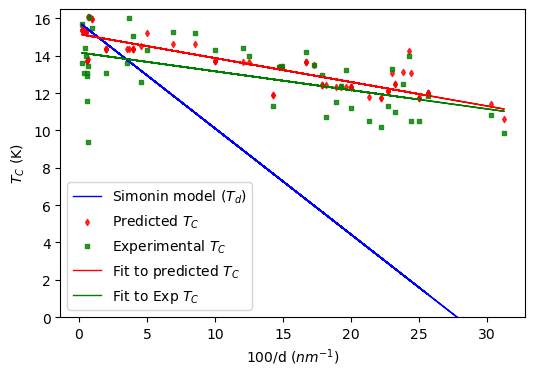

In [260]:
plt.style.use('default')

plt.figure(figsize=(6,4))
plt.plot(x_s, td_s, lw=1.0, c='b', label='Simonin model ($T_d$)')
plt.scatter(x_s, df3.predicted_Tc, marker='d', s=10, c='r', label='Predicted $T_C$', alpha=0.8)
plt.scatter(x_s2, df2.Tc_K, marker='s', s=10, c='g', label='Experimental $T_C$', alpha=0.8)
#plt.scatter(x_s, y_fit3, c='m')

#find line of best fit
a, b = np.polyfit(x_s, df3.predicted_Tc, 1)
#add line of best fit to plot
y=[a*i+b for i in x_s]
plt.plot(x_s, y, c='r', lw=1.0, label='Fit to predicted $T_C$')


#find line of best fit
a2, b2 = np.polyfit(x_s2, df2.Tc_K, 1)
#add line of best fit to plot
y2=[a2*i+b2 for i in x_s2]
plt.plot(x_s2, y2, lw=1.0, c='g', label='Fit to Exp $T_C$')


plt.xlabel(r'100/d ($nm^{-1}$)', fontsize=10)
plt.ylabel('$T_C$ (K)', fontsize=10)

#plt.xlim(-1,26)
plt.ylim(0,16.5)
plt.legend(loc='best')
#plt.savefig(pwd + '/Simonin.png', dpi=1000, bbox_inches="tight")
plt.show()